In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [2]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

In [3]:
def build_dataset(words):
    block_size = 3  # Context size
    X = []
    Y = []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join([itos[i] for i in context]), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.LongTensor(X)
    Y = torch.LongTensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
#emb = C[Xtr] #Pytoch indexind works directly on the first dimension
# emb.shape

#W1 = torch.rand((6, 100))
#b1 = torch.rand((100))

# How to h = emb. @ W1 + b1
# One way to do this
# torch.cat(torch.unbind(emb, 1), 1).shape # Generalizes to all block sizes 
# New memory is allocated for this operation

# torch.view is another way to do this : It is much more efficient and faster
# Reason is that it does not create a new tensor, it just changes the view of the tensor
# It changes the meta data of the tensor

# Read up internals of pytorch to understand this better 

#h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # No new memory is allocated here beccause of view
#h.shape

# W2 = torch.rand((100, 27))
# b2 = torch.rand((27))

# logits = h @ W2 + b2
# logits.shape
# # Like in previous example, we exp the logits and normalize them (softmax)
# probs = logits.exp() / logits.exp().sum(-1, keepdim=True)
# avg_nll = probs[torch.arange(Y.shape[0]), Y].log().mean()
# print(avg_nll)

In [5]:
###### Clean up ######

g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27, 10), generator=g, requires_grad=True)
W1 = torch.rand((30, 200), generator=g, requires_grad=True)
b1 = torch.rand((200), generator=g, requires_grad=True)
W2 = torch.rand((200, 27), generator=g, requires_grad=True)
b2 = torch.rand((27), generator=g, requires_grad=True)
params = [C, W1, b1, W2, b2]

sum(p.nelement() for p in params) # Number of parameters


11897

In [6]:
for p in params:
    p.requires_grad = True

In [10]:
batch_size = 32
iters = 50000
#lre = torch.linspace(-3, 0, iters)
#lrs = 10**lre

lri =[]
lossi = []
stepi = []

for i in range(iters):

    # minibatch
    ix = torch.randint(0, len(Xtr), (batch_size,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (Eamples, 100)
    logits = h @ W2 + b2
    probs = logits.exp() / logits.exp().sum(-1, keepdim=True)
    loss = -probs[torch.arange(batch_size), Ytr[ix]].log().mean() # Creates new memory

    loss = F.cross_entropy(logits, Ytr[ix]) # Does not create new memory (Foward pass)
    # This makes backpropagation easier as well. Due to clustering the operations
    # It also take ccase of dynamic range ... ex: exp(1000) will not work but cross entropy will work


    for param in params:
        param.grad = None
    loss.backward()
    
    #lr = lrs[i]
    lr = 0.01
    for p in params:
        p.data += -lr * p.grad
    
    #lri.append(lr)   
    lossi.append(loss.item())
    stepi.append(i)

    print(loss.item())


2.312196969985962
2.1955368518829346
1.7902894020080566
2.305274724960327
2.081080436706543
2.3293495178222656
2.3997113704681396
2.393749713897705
2.755131959915161
2.1777119636535645
2.3253533840179443
2.331423759460449
1.8122450113296509
2.2361459732055664
2.2901599407196045
2.1260650157928467
2.2844982147216797
2.2906570434570312
2.1746795177459717
2.2442941665649414
1.9769175052642822
2.4374020099639893
1.951011061668396
2.744055986404419
2.3464035987854004
2.0393011569976807
2.1799697875976562
2.4514007568359375
2.2181169986724854
2.6861586570739746
1.8439433574676514
2.5482985973358154
1.7631133794784546
1.921291470527649
2.133134365081787
2.0989410877227783
1.7863249778747559
2.011282444000244
2.0807652473449707
2.476060628890991
2.0797533988952637
2.3301661014556885
2.18912935256958
2.602017641067505
2.296705484390259
2.1234912872314453
2.3166985511779785
1.8995709419250488
2.5251197814941406
2.118678569793701
2.1620800495147705
2.3791122436523438
1.8383837938308716
2.43197393

In [15]:
# Using the model to predict 
g = torch.Generator().manual_seed(2147483647)
block_size = 3
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.LongTensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        out.append(ix)
        if ix == 0:
            break
        context = context[1:] + [ix]
    
    print(''.join([itos[i] for i in out]))

junide.
janasid.
prefay.
adria.
shin.
tolia.
saree.
kalania.
zamilenias.
deyainroi.
tavin.
siely.
arter.
nomanthif.
etume.
ponnsleigh.
azi.
cora.
yar.
ocetreyah.


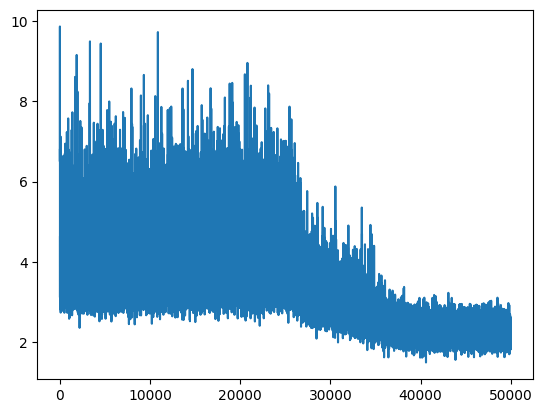

In [8]:
#plt.plot(lri, lossi) # Used to pick out a loss
plt.plot(stepi, lossi) # Used to pick out a loss

In [16]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f'dev Loss: {loss.item()}')

# emb = C[Xte]
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# logits = h @ W2 + b2
# loss = F.cross_entropy(logits, Yte)
# print(f'test loss {loss.item()}')
      
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f'train loss {loss.item()}')


dev Loss: 2.1822428703308105
train loss 2.166449785232544


In [ ]:
# In production, one would make train, test and dev/validation split

# One is allowed to test on the test split only a few times
# Generally 80% train, 10% test, 10% validation


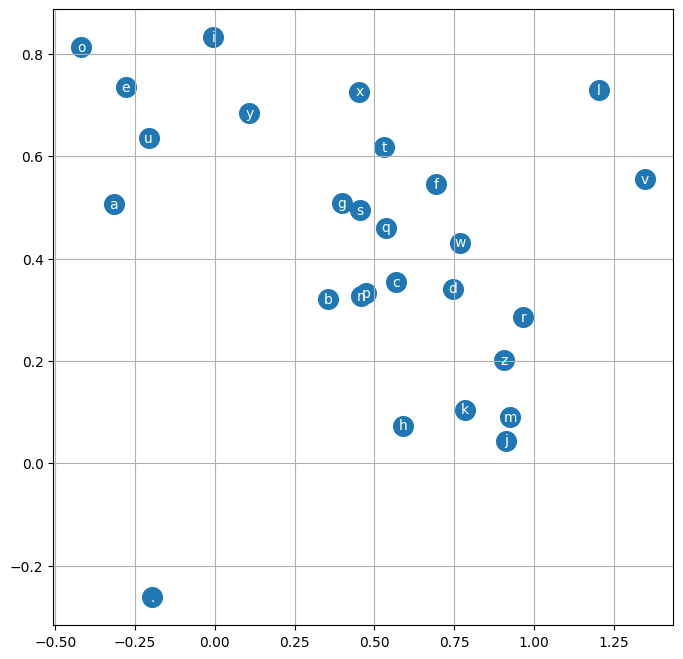

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')